# CoRise Practice A/B Testing Course: Project 2


## Background

Welcome back to **TinyTravelers**, you extraordinary product data scientist! It’s been a few months, and you and your team are rolling now! Carrying over from the work you did last week- the team is sticking with new booked listings as the target metric, new cancelled listings as the guardrail, and new active listings as an informative metric.

This time, four A/B tests need to be designed and analyzed. There may be some surprising results, so be sure to analyze the results carefully! The test data is simulated, but that doesn't mean that we've simulated a flawless run of the test. If you're surprised by your results, think carefully about what could have caused them.

Note that for analysis, we are now providing some segmentation information about each user: continent, device, and if they have been a host on Tiny Travelers before. This information will be helpful for some of the tests but not all.

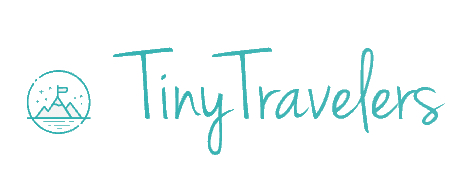

## Setup

Load data into Google Collab (skip this block if you are running it outside collab).

In [1]:
!pip install -U --no-cache-dir gdown --pre
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1pwAZPlhtiJpWsHK2vMOvX7iwzOqY0O7d/view?usp=share_link
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1gKvqbiObYdmTFHwhzrF25OMBKnbSx_au/view?usp=share_link
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/17k9aW-NoWlK0Ie63sVgj2byHNNq_AUbh/view?usp=share_link
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1ZbWLURabej9CW520TrlKG-HEPVgGT4cd/view?usp=share_link


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From: https://drive.google.com/uc?id=1pwAZPlhtiJpWsHK2vMOvX7iwzOqY0O7d
To: /content/dataset_default_calendar.csv
100% 4.12M/4.12M [00:00<00:00, 249MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gKvqbiObYdmTFHwhzrF25OMBKnbSx_au
To: /content/dataset_africa_map.csv
100% 9.93M/9.93M [00:00<00:00, 132MB/s]
Downloading...
From: https://drive.google.com/uc?id=17k9aW-NoWlK0Ie63sVgj2byHNNq_AUbh
To: /content/dataset_split_page.csv
100% 5.61M/5.61M [00:00<00:00, 190MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZbWLURabej9CW520TrlKG-HEPVgGT4cd
To: /content/dataset_upload_photos.csv
100% 218k/218k [00:00<00:00, 118MB/s]


Import libraries

In [2]:
# Lirbary basics
import numpy as np
import pandas as pd
import scipy.stats as stats # For pvalue

# For markdown display
from IPython.display import Image

Helper function to get the 95% confidence interval. Inputs:
* Mean treatment - average conversion rate of the treatment group
* Mean control - average conversion rate of the control group
* N treatment - number of samples in the treatment group
* N control - number of samples in the control group
* ci = The width of the confidence interval. 0.95 by default

You can read more about the math behind the confidence interval function [here](https://s3.amazonaws.com/assets.datacamp.com/production/course_6165/slides/chapter4.pdf).

In [3]:
def get_ci(mean_treatment, mean_control, n_treatment, n_control, ci = 0.95):
    sd = ((mean_treatment * (1 - mean_treatment)) / n_treatment + (mean_control * (1 - mean_control)) / n_control)**0.5
    lift = mean_treatment - mean_control
    val = stats.norm.isf((1 - ci) / 2)
    lwr_bnd = lift - val * sd
    upr_bnd = lift + val * sd
    return((lwr_bnd, upr_bnd))

Helper function to calcuate the results. It will compute and return the relative and absolute lift between variant and control, p-value, and lower and upper bound for the 95% confidence interval. A standard two-sided t-test with an assumption of equal variance is used to compute the p-value.

Inputs:
* DF = data frame with each row being a sample in the A/B test. It must have a column called "variant" that takes on the value "control" or "treatment
* Metric = the metric we want to evaluate. This must be 'new_active_listings','new_booked_listings', or 'new_cancelled_listings'). If it is not one of these values an "invalid metric" error will be thrown.

In [4]:
def calculate_results(df,metric):
    # Check
    if metric not in ('new_active_listing','new_booked_listing','new_cancelled_listing'):
        raise Exception("Invalid metric")
    
    # Values and relative difference
    mean_control = df.loc[df['variant'] == "control",metric].mean()
    mean_treatment = df.loc[df['variant'] == "treatment",metric].mean()
    
    abs_diff = mean_treatment-mean_control
    rel_diff = (mean_treatment-mean_control)/mean_control

    # P-Value -- two-sided ttest, assumes normal distribution 
    data_group1 = list(df.query('variant == "control"')[metric])
    data_group2 = list(df.query('variant == "treatment"')[metric])

    results = stats.ttest_ind(a=data_group1, b=data_group2, equal_var=True)
    pvaue = results.pvalue

    # 95% confidence intervals 
    [ci_low, ci_high] = get_ci(mean_treatment,mean_control,len(data_group2),len(data_group1),.95)
    ci_low = ci_low/mean_control
    ci_high = ci_high/mean_control
    
    return(rel_diff,abs_diff,results.pvalue,ci_low,ci_high)

## Task 1: Design and analyze a test - Default open calendar
Hosts start on TinyTravelers with an entirely blocked calendar. Meaning they need to toggle the dates to be bookable. The team hypothesizes that new booked listings can increase if they start with a default available calendar and toggle dates to block them instead. 

The UI change is shown below.

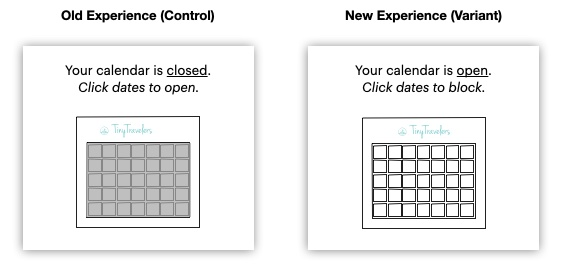

### Task 1.a. Test design by answering the following...

First, we want to determine how to implement the test, and what it is that we're testing for. With that in mind, you'll first need to decide when the test should be triggered: what should trigger the start of the test? Second, you'll need to decide what our hypothesis is. And remember, we're building on what we learned last week, so don't be afraid to look over your Week 1 project if it will help you!

#### Task 1.a.i. When should the test be triggered?

| ------------------- _Answer_ ------------------- |

Ideally, users should be assigned to either the old experience (calendar is closed by default) or new experience (calendar is open by default) as close to the proposed change in the product experience as possible.

Here, that would mean users are assiged to see either the old experience or new experience immediately before they encounter the calendar in the onboarding flow.

| ---------------------------------------------------- |

#### Task 1.a.ii. What is the hypothesis?

| ------------------- _Answer_ ------------------- |

You might phrase the hypothesis for this experiment like this:

_If we switch the calendar from closed by default to open by default, New Booked Listings will increase, because there will be more dates available for guests to book._ 

| ---------------------------------------------------- |

#### Task 1.a.iii. How long should the test run and how will the launch/ no launch decision be made?

You can assume that about 5K new users arrive in the flow each day. And the cohort to book rate is 25% because the cohorting happens later in the flow when only the higher intent people are still there. You can use an online sample size calculate (e.g. Evan Miller's [sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html)).

| ------------------- _Answer_ ------------------- |

It looks like we don't already have a minimum detectable effect size in mind.

Given a 25% baseline conversion rate and assuming...

- a 50/50 split between control and treatment,
- a significance level of 5%,
- statistical power of 80%,

...here are some options for how long we'll need to run the experiment based on the minimum detectable relative effect size we want:

**5% relative effect**

- We need at least 18,929 users in each variant, for a total of 37,858 users in the experiment
- Assuming 5,000 users hit the trigger point each day, that suggests 37,858 / 5,000 ≈ 7 or 8 days to reach our minimum required sample size.
- Since it will take another week for those new listings to get their first booking (or not), the experiment will need to run for **14 or 15 days**.

**4% relative effect**

- We need at least 29,549 users in each variant, for a total of 59,098 users in the experiment
- Assuming 5,000 users hit the trigger point each day, that suggests 59,098 / 5,000 ≈ 11 or 12 days to reach our minimum required sample size.
- Since it will take another week for those new listings to get their first booking (or not), the experiment will need to run for **18 or 19 days**.

**2% relative effect**

- We need at least 117,966 users in each variant, for a total of 235,992 users in the experiment
- Assuming 5,000 users hit the trigger point each day, that suggests 59,098 / 5,000 ≈ 47 or 48 days to reach our minimum required sample size.
- Since it will take another week for those new listings to get their first booking (or not), the experiment will need to run for **54 or 55 days**. Given that this is almost 8 weeks, this might be longer than we're willing to wait.

For the purposes of this project, let's assume we're going to aim for a **4% minimum relative effect size**.

We'll plan to roll out the calendar change if:

- We see a relative increase of at least 4% in New Booked Listings
- The result is statistically significant
- There isn't a negative impact on our guardrail metric, New Canceled Listings

| ---------------------------------------------------- |

### Task 1.b. Test analysis

Please analyze the test and summarize the learnings and recommendations for PaM and the team below with the A/B test data provided. The data has already been cleaned for you. There is information for three milestones:

* new_active_listing - 1 if a user published their listing during experiment. Otherwise 0.
* new_booked_listing - 1 if a user received a guest booked on a new listing during the experiment. Otherwise 0.
* new_cancelled_listing - 1 if a user cancelled a new booking during the experiment. Otherwise 0. 

We also provided some segmentation information for each user.
* continent - the continent for the host, either 'asia','north_america','south_america','australia','europe','africa'
* booked_previously - 1 if the host has hosted before the started the onboarding flow (because they have a home on a different platform like Airbnb).
* device - the device the host is using when starting the onboarding flow. Either 'android', 'ios' or 'web'.

In [5]:
df_calendar = pd.read_csv('/content/dataset_default_calendar.csv') # Load the data

In [6]:
results_nal = calculate_results(df_calendar, 'new_active_listing')
results_nbl = calculate_results(df_calendar, 'new_booked_listing')
results_ncl = calculate_results(df_calendar, 'new_cancelled_listing')

results = pd.DataFrame(
    {
        'new_active_listing': results_nal,
        'new_booked_listing': results_nbl,
        'new_canceled_listing': results_ncl,
    },
    index=['rel_diff','abs_diff','pvalue','ci_low','ci_high']
)

results

,new_active_listing,new_booked_listing,new_canceled_listing
rel_diff,-0.010038,0.047134,0.234726
abs_diff,-0.004048,0.008155,0.001958
pvalue,0.183992,0.000590,0.001050
ci_low,-0.024845,0.020253,0.094394
ci_high,0.004770,0.074015,0.375058


| ------------------- _Answer_ ------------------- |

For our target metric, these results show a relative increase in New Booked Listings of 4.7%.
The change is statistically significant, with $p = 0.0006$.
This looks good!

On the other hand, for our guardrail metric, the results show a relative increase in New Canceled Listings of 23.5%.
This change is also statistically significant, with $p = 0.001$.

It's a judgement call for the business whether the positive impact on our target metric, New Booked Listings, outweight the negative impact on our guardrail metric, New Canceled Listings.
However, a 23% increase in canceled listings seems like a very large negative effect, so I'd recommend caution.

| ---------------------------------------------------- |

##### Hint - Click to unhide

Given the segments that are provided in the table (continent, device, experience hosting), might be there be a group that is impacted differently that others?

| ------------------- _Answer_ ------------------- |

It's plausible that hosting experience might play a role here.

Users who are totally new to hosting may not know how to manage their listing's calendar yet.
With an open calendar by default, they may inadventently leave open dates they didn't mean to.
This could result in more cancelations, as guests try to book dates that don't actually work for the new hosts.

Users with previous hosting experience, on the other hand, may already be savvy about managing their listing's calendar, and may not experience the same uptick in cancelations.

We can investigate this by segmenting the data by hosting experience and re-running the statistical analysis.

| ---------------------------------------------------- |

In [7]:
df_calendar_never_booked = df_calendar[df_calendar['booked_previously'] == 0]

results_nal_never_booked = calculate_results(df_calendar_never_booked, 'new_active_listing')
results_nbl_never_booked = calculate_results(df_calendar_never_booked, 'new_booked_listing')
results_ncl_never_booked = calculate_results(df_calendar_never_booked, 'new_cancelled_listing')

results = pd.DataFrame(
    {
        'new_active_listing': results_nal_never_booked,
        'new_booked_listing': results_nbl_never_booked,
        'new_canceled_listing': results_ncl_never_booked,
    },
    index=['rel_diff','abs_diff','pvalue','ci_low','ci_high']
)

results

,new_active_listing,new_booked_listing,new_canceled_listing
rel_diff,-0.007542,0.015535,0.280784
abs_diff,-0.003039,0.002687,0.002374
pvalue,0.372231,0.308023,0.000471
ci_low,-0.024109,-0.014333,0.123413
ci_high,0.009024,0.045403,0.438154


In [8]:
df_calendar_previously_booked = df_calendar[df_calendar['booked_previously'] == 1]

results_nal_previously_booked = calculate_results(df_calendar_previously_booked, 'new_active_listing')
results_nbl_previously_booked = calculate_results(df_calendar_previously_booked, 'new_booked_listing')
results_ncl_previously_booked = calculate_results(df_calendar_previously_booked, 'new_cancelled_listing')

results = pd.DataFrame(
    {
        'new_active_listing': results_nal_previously_booked,
        'new_booked_listing': results_nbl_previously_booked,
        'new_canceled_listing': results_ncl_previously_booked,
    },
    index=['rel_diff','abs_diff','pvalue','ci_low','ci_high']
)

results

,new_active_listing,new_booked_listing,new_canceled_listing
rel_diff,-0.019953,1.718500e-01,0.041400
abs_diff,-0.008075,2.975173e-02,0.000326
pvalue,0.236386,4.478601e-08,0.793156
ci_low,-0.052980,1.103693e-01,-0.267933
ci_high,0.013074,2.333307e-01,0.350732


| ------------------- _Answer_ ------------------- |

This analysis shows a very clear divide between users who have never hosted before and users who have prior hosting experience.

For users who have **never hosted before**

- The relative increase in new booked listings drops to 1.6%, and the result is no longer statistically significant ($p=0.31$).
- The relative increase in new canceled listings increases to 28% and remains highly statistically signficant ($p=0.0005$).

For users **with prior hosting experience**

- The relative increase in new booked listings increases to 17%, and the result is highly statistically signficant ($p ≈ 0$).
- The relative increase in new canceled listings drops to 4.2%, and the result is no longer statistically significant ($p=0.79$).

We should be aware that we're engaging in multiple hypothesis testing here.
In this case, we can apply the Bonferroni adjustment.
The p-values are so low that our results will still be statistically significant event compared to a Bonferroni-corrected p-value threshold.

This analysis suggests launching the change, but _only_ for users who have prior hosting experience.
If we wanted to play it safe, we could run a second A/B test that only includes users with prior hosting experience to confirm the results.

| ---------------------------------------------------- |

## Task 2: Email to upload photos

In the onboarding flow, there is a significant drop-off on the "upload a photo" page. The team hypothesizes that people leave to take a photo, get distracted by something else, and don't return. They want to try emailing those who dropped out on the upload a photo page and have not uploaded a photo within 24 hours of leaving the flow. They also want to add encouraging text to those returning to the flow.

Specifically:

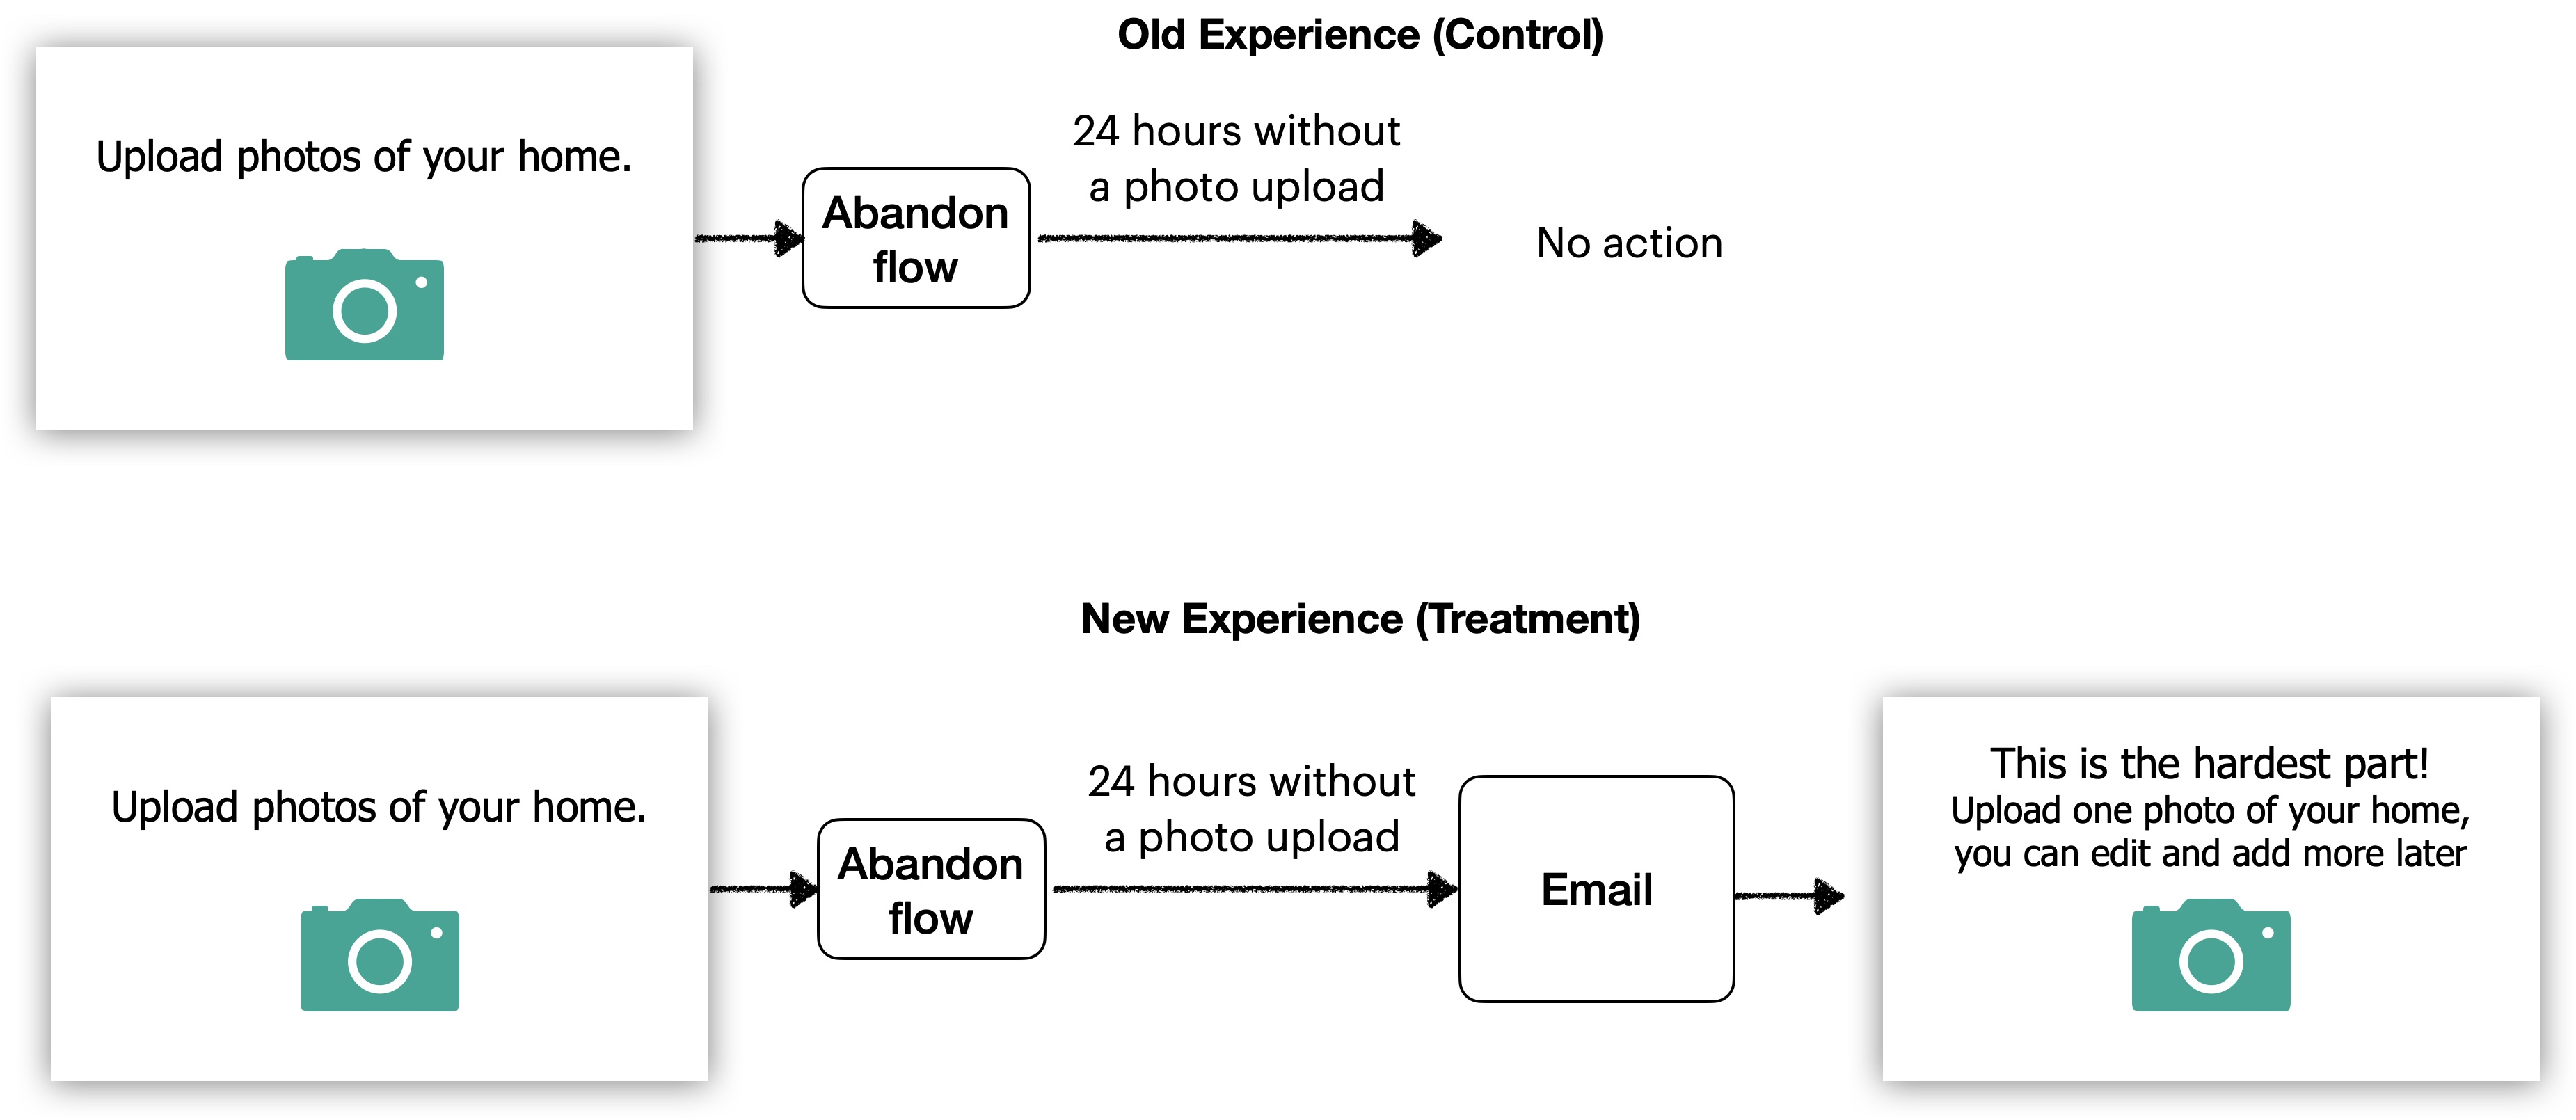

### Task 2.a. Test design by answering the following...

Like task 1, we want to determine how to implement the test, and what it is that we're testing for by completing the below steps. 

#### Task 2.a.i. When should the test be triggered?

| ------------------- _Answer_ ------------------- |

Ideally, users should be assigned to either the old experience (no reminder email after 24 hours) or new experience (send a reminder email after 24 hours) as close to the proposed change in the product experience as possible.

Here, that would mean users are assiged to either control or treatment groups immediately before we're about to send the email — i.e., after 24 hours without a photo upload.

| ---------------------------------------------------- |

#### Task 2.a.ii. What is the hypothesis?

| ------------------- _Answer_ ------------------- |

You might phrase the hypothesis for this experiment like this:

_If we send users who have waited 24 hours without uploading a photo a reminder email, New Booked Listings will increase, because more of these users will return to complete the onboarding flow and publish their listings._ 

| ---------------------------------------------------- |

#### Task 2.a.iii. How long should the test run and how will the launch/ no launch decision be made?

Assume that there are 1000 new users visiting the triggering point each day and the cohort-book rate for that group is 10%. This is because we're subsetting to the users who exit the flow and they're unlikely to convert on their own. After all, they did leave the flow in the first place. PaM doesn't have a prior on how long she's willing to run it or how big of a change she expects, so please bring her some options.

You can use an online sample size calculate (e.g. Evan Miller's [sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html)).

| ------------------- _Answer_ ------------------- |

Given a 10% baseline conversion rate and assuming...

- a 50/50 split between control and treatment,
- a significance level of 5%,
- statistical power of 80%,

...here are some options for how long we'll need to run the experiment based on the minimum detectable relative effect size we want:

**5% relative effect**

- We need at least 56,885 users in each variant, for a total of 113,770 users in the experiment
- Assuming 1,000 users hit the trigger point each day, that suggests 113,770 / 1,000 ≈ 114 days to reach our minimum required sample size.
- Since it will take another week for those new listings to get their first booking (or not), the experiment will need to run for about **121 days**.
This probably isn't a practical timeline for our test.

**10% relative effect**

- We need at least 14,313 users in each variant, for a total of 28,626 users in the experiment
- Assuming 1,000 users hit the trigger point each day, that suggests 28,626 / 1,000 ≈ 28 or 29 days to reach our minimum required sample size.
- Since it will take another week for those new listings to get their first booking (or not), the experiment will need to run for **34 or 35 days**.

**15% relative effect**

- We need at least 6,401 users in each variant, for a total of 12,802 users in the experiment
- Assuming 1,000 users hit the trigger point each day, that suggests 12,802 / 1,000 ≈ 12 or 13 days to reach our minimum required sample size.
- Since it will take another week for those new listings to get their first booking (or not), the experiment will need to run for **19 or 20 days**.

We'll plan to roll out the calendar change if:

- We see a relative increase in New Booked Listings of at least the minimum effect threshold we choose
- The result is statistically significant
- There isn't a negative impact on our guardrail metric, New Canceled Listings

| ---------------------------------------------------- |

### Task 2.b. Analysis

After discussing the options with PaM, you collectively decided to run the test for 35 days to detect a 10% change or greater with a little buffer. Those in the control group who return to the flow probably need more time to publish and book than the average host, so you want to ensure you build in time to capture those conversions.

Please analyze the results and summarize the findings and recommendations below. The data has already been cleaned for you. Like with previous tasks, the table contains information for three milestones:

* new_active_listing - 1 if a user published their listing during experiment. Otherwise 0.
* new_booked_listing - 1 if a user received a guest booked on a new listing during the experiment. Otherwise 0.
* new_cancelled_listing - 1 if a user cancelled a new booking during the experiment. Otherwise 0. 

We also provided some segmentation information for each user.
* continent - the continent for the host, either 'asia','north_america','south_america','australia','europe','africa'
* booked_previously - 1 if the host has been booked before the started the onboarding flow (because they hosted on other platforms like Airbnb). Otherwise 0.
* device - the device the host is using when starting the onboarding flow. Either 'android', 'ios' or 'web'.

In [9]:
df_upload_photos = pd.read_csv('/content/dataset_upload_photos.csv')

results_nal = calculate_results(df_upload_photos, 'new_active_listing')
results_nbl = calculate_results(df_upload_photos, 'new_booked_listing')
results_ncl = calculate_results(df_upload_photos, 'new_cancelled_listing')

results = pd.DataFrame(
    {
        'new_active_listing': results_nal,
        'new_booked_listing': results_nbl,
        'new_canceled_listing': results_ncl,
    },
    index=['rel_diff','abs_diff','pvalue','ci_low','ci_high']
)

results

,new_active_listing,new_booked_listing,new_canceled_listing
rel_diff,-4.381678e-01,-4.447534e-01,-0.326331
abs_diff,-2.899104e-01,-6.195109e-02,-0.001187
pvalue,2.783675e-98,1.376330e-13,0.429576
ci_low,-4.779064e-01,-5.719729e-01,-1.186573
ci_high,-3.984292e-01,-3.175338e-01,0.533912


| ------------------- _Answer_ ------------------- |

These results suggest something might be wrong with the test.
For instance:

- We're seeing very large effect sizes: roughly a 44% relative decrease in the treatment group versus the control group on both New Booked Listings and New Active Listings.
- The results are _too_ statistically significant: the p-values are effectively 0.

We can analyze the data further to investigate.

| ---------------------------------------------------- |

In [10]:
df_upload_photos.describe()

,id_user,booked_previously,new_active_listing,new_booked_listing,new_cancelled_listing
count,5596.000000,5596.000000,5596.000000,5596.000000,5596.000000
mean,1536.451394,0.194425,0.471408,0.098642,0.002859
std,1008.740120,0.395792,0.499226,0.298207,0.053400
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,699.750000,0.000000,0.000000,0.000000,0.000000
50%,1400.000000,0.000000,0.000000,0.000000,0.000000
75%,2274.250000,0.000000,1.000000,0.000000,0.000000
max,3674.000000,1.000000,1.000000,1.000000,1.000000


| ------------------- _Answer_ ------------------- |

We can see the first problem: there aren't enough users in the experiment overall.

Our original design called for 28,000+ users, split 50/50 between the control and treatment groups.
Based on the analysis above, we can see there are a little less than 6,000 user records in our results dataset.

It seems like users are dropping out of the experiment somewhere.

We can continue our investigation by analyzing the users in the control and treatment groups separately.

| ---------------------------------------------------- |

In [11]:
df_upload_photos['variant'].value_counts()

treatment    3672
control      1924
Name: variant, dtype: int64

In [12]:
df_photos_control = df_upload_photos.groupby('variant').get_group('control')

df_photos_control.describe()

,id_user,booked_previously,new_active_listing,new_booked_listing,new_cancelled_listing
count,1924.000000,1924.000000,1924.000000,1924.000000,1924.000000
mean,962.454782,0.190229,0.661642,0.139293,0.003638
std,555.630110,0.392584,0.473274,0.346342,0.060224
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,481.750000,0.000000,0.000000,0.000000,0.000000
50%,962.500000,0.000000,1.000000,0.000000,0.000000
75%,1443.250000,0.000000,1.000000,0.000000,0.000000
max,1924.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df_photos_treatment = df_upload_photos.groupby('variant').get_group('treatment')

df_photos_treatment.describe()

,id_user,booked_previously,new_active_listing,new_booked_listing,new_cancelled_listing
count,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000
mean,1837.205610,0.196623,0.371732,0.077342,0.002451
std,1061.126003,0.397499,0.483333,0.267170,0.049453
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,918.750000,0.000000,0.000000,0.000000,0.000000
50%,1837.500000,0.000000,0.000000,0.000000,0.000000
75%,2755.250000,0.000000,1.000000,0.000000,0.000000
max,3674.000000,1.000000,1.000000,1.000000,1.000000


| ------------------- _Answer_ ------------------- |

It appears that our experiment suffers from an assignment imbalance.
There are 3,672 users in our treatment data, but only 1,924 users in our control data.
That's nowhere near the 50/50 split we were expecting.
It looks like a substantial number of users have dropped out of our experiment somewhere, and there are systematic differences about which users dropped out between the treatment and control groups.

Unfortunately, this assignment imbalance error likely means our results are flawed and we can't use this data to support decision-making.

For what it's worth, it looks like the users in the control group completed the onboarding flow at a much higher rate.
The New Active Listing conversion rate for the control group is 66%, compared to just 37% for the treatment group.
Users in the control group may have been higher-intent users.
If they abandoned the onboarding flow for at least 24 hours, then returned to it without a reminder, maybe they were more likely to complete the flow in any case.

If we still need these results, I would recommend identifying where the bug or flaw is in our experimental design, then re-running the test.

| ---------------------------------------------------- |

##### Hint - Click to unhide

Remember the two errors we talked about in class this week and how you know if they are present:
* [Assignment imbalance](https://corise.com/course/practical-ab-testing/v2/module/setup-errors#corise_clhv0h9j200003b7moycd4wbg)
* [Dilution](https://corise.com/course/practical-ab-testing/v2/module/setup-error-dilution#corise_clhv06v9s000i3b6rxqf5nkpo)

Do you see anything off here?

## Task 3: Break out into two pages

You've noticed that only a few hosts are selecting amenities, and with offline correlation analysis, you found that amenities are connected to the likelihood of being booked. The team hypothesizes that hosts might not be selecting the amenities because it's low on a long page, so they want to test putting it on its own page.

See the UI change below.

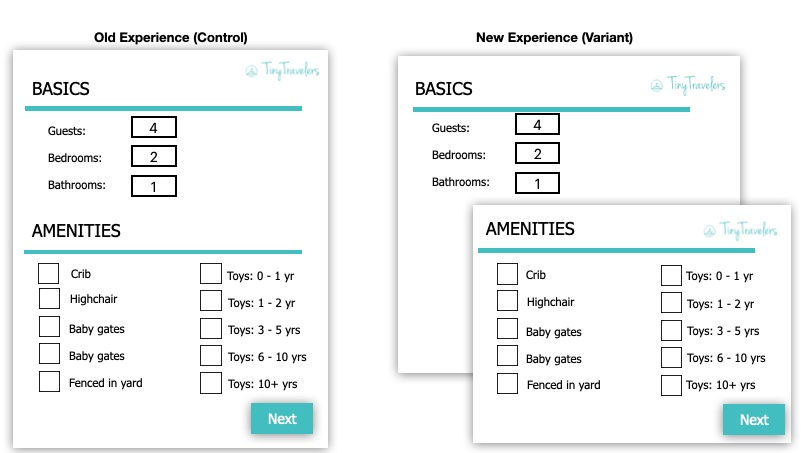

### Task 3.a. Test design by answering the following...

#### Task 3.a.i. When should the test be triggered?

| ------------------- _Answer_ ------------------- |

Ideally, users should be assigned to either the old experience ("basics" and "amenities" on the same page) or new experience (separate pages for "basics" and "amenities") as close to the proposed change in the product experience as possible.

Here, that would mean users are assiged to either control or treatment groups immediately before they encounter the "basics" section in the onboarding flow.

| ---------------------------------------------------- |

#### Task 3.a.ii. What is the hypothesis?

| ------------------- _Answer_ ------------------- |

You might phrase the hypothesis for this experiment like this:

_If we put the "amenities" section on its own page, New Booked Listings will increase, because users will be more likely to add amenities to their listing, and we believe listings with amenities are more likely to receive bookings._ 

| ---------------------------------------------------- |

#### Task 3.a.iii. How long should the test run and how will the launch/ no launch decision be made?

You can assume that about 5K new users arrive in the flow each day. And the cohort to book rate is 20%. You can use an online sample size calculate (e.g. Evan Miller's [sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html)).

| ------------------- _Answer_ ------------------- |

Let's assume we want a minimum detectable relative effect size of 4%.
Assuming a statistical power of 80%, a significance level of 5%, and a 50/50 split between control and treatment, we'll need at least 39,418 users in each group, for a total of at least 78,836 users in the experiment.

If 5,000 new users hit the triggering point each day, that implies we'll need to wait 15-16 days to reach our minimum required sample size.
Since it will take another week for those listings to receive their first booking (or not), that means we'll need to run the experiment for 22-23 days, total.

We'll decide to launch if:

- We see a relative increase in New Booked Listings of at least 4%
- The results is statistically significant
- There isn't a substantial negative impact on our guardrail metric, New Canceled Listings

| ---------------------------------------------------- |

### Task 3.b. Test analysis

Please analyze the test and summarize the learnings and recommendations for PaM and the team below with the A/B test data provided. The data has already been cleaned for you. There is information for three milestones:

* new_active_listing - 1 if a user published their listing during experiment. Otherwise 0.
* new_booked_listing - 1 if a user received a guest booked on a new listing during the experiment. Otherwise 0.
* new_cancelled_listing - 1 if a user cancelled a new booking during the experiment. Otherwise 0. 

We also provided some segmentation information for each user.
* continent - the continent for the host, either 'asia','north_america','south_america','australia','europe','africa'
* booked_previously - 1 if the host has been booked before the started the onboarding flow (because they have another home on TinyTravels). Otherwise 0.
* device - the device the host is using when starting the onboarding flow. Either 'android', 'ios' or 'web'.

_Basic_: What happened at a high-level to the target (new booked listings) and guardrail (new cancelled listings) and do you recommend a launch or not based on that?

_Bonus_: Given unlimited time, what follow-up analysis and testing might you do? (No coding on this- just thinking).

In [18]:
df_split_page = pd.read_csv('/content/dataset_split_page.csv') # Load data

results_nal = calculate_results(df_split_page, 'new_active_listing')
results_nbl = calculate_results(df_split_page, 'new_booked_listing')
results_ncl = calculate_results(df_split_page, 'new_cancelled_listing')

results = pd.DataFrame(
    {
        'new_active_listing': results_nal,
        'new_booked_listing': results_nbl,
        'new_canceled_listing': results_ncl,
    },
    index=['rel_diff','abs_diff','pvalue','ci_low','ci_high']
)

results

,new_active_listing,new_booked_listing,new_canceled_listing
rel_diff,-0.027348,0.047285,0.074152
abs_diff,-0.010846,0.003938,0.000181
pvalue,0.000033,0.008456,0.501356
ci_low,-0.040263,0.012097,-0.141951
ci_high,-0.014433,0.082473,0.290255


| ------------------- _Answer_ ------------------- |

These results show a mixed outcome.

Looking only at our target metric, New Booked Listings, we see a relative increase of 4.7%, and the result is statistically significant ($p=0.008$).
This would suggest we launch the change.

Looking at our guardrail metric, New Canceled Listings, we see a relative increase of 7.4%.
The absolute increase is tiny, though, and the result is not statistically significant ($p=0.5$).
This probably isn't enough evidence to deter a launch.

Looking at our informative metric, New Active Listings, we see a relative decline of 2.7%, and the result is statistically significant ($p=0.00003$).
This might indicate that the change has added friction to the onboarding process, and as a result some users aren't completing the onboarding flow and publishing their listings.

It would be a judgement call for the business whether or not to launch based on these mixed results.
If I had to give a recommendation, I would say the increase in New Booked Listings outweighs the decrease in New Active Listings and New Canceled Listings, and I would recommend a launch.

Given unlimited time and resources, I might do follow-up analysis to:

- Explore the decreases in New Active Listings and New Canceled Listings
- Explore whether the change in content affects page load times, and whether that causes users to drop out of the experiment
- Test to see if users on different devices respond to the changes differently.
Maybe the "too much information on one page" effect plays out differently for users on mobile devices vs. laptop or desktop computers.

Additionally, I noticed there's a size imbalance between the control and treatment groups again.

| ---------------------------------------------------- |

In [33]:
df_split_page['variant'].value_counts()

treatment    70220
control      69278
Name: variant, dtype: int64

In [34]:
import scipy.stats as stats

treatment_group_size = 70220
control_group_size = 69278
total = control_group_size + treatment_group_size

expected_group_size = total / 2

observed = [control_group_size, treatment_group_size]
expected = [expected_group_size, expected_group_size]

chi_squared_stat, p_value = stats.chisquare(observed, expected)

print("Chi-squared statistic:", chi_squared_stat)
print("p-value:", p_value)

Chi-squared statistic: 6.361123456967125
p-value: 0.011664766130087462


| ------------------- _Answer_ ------------------- |

We can use a Chi-squared test to determine if the difference is statistically significant.

Assuming we were expecting a 50/50 split between treatment and control, this suggests there's a statistically significant imbalance in the sizes of the treatment and control groups ($p=0.01$).

I'm not sure exactly what this imbalance means for the results of our test.

| ---------------------------------------------------- |

## Task 4: New map service for Africa

It is a known problem that the company you work with to confirm and locate the address of a home struggles a LOT in Africa. User research has found that hosts in Africa need to spend a substantial amount of time moving the pin to find their actual location from the suggested spot- if they find it at all. You hypothesize this is the primary reason conversion is so low through the maps section of the onboarding flow. A new player has come on the market, and the team wants to determine if using them helps with conversion through the maps section (see below). Since the change is on the backend, the UI would look mostly the same.

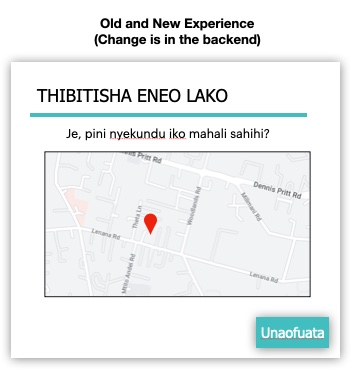

### Task 4.a. Test design by answering the following...

#### Task 4.a.i. When should the test be triggered?

| ------------------- _Answer_ ------------------- |

Ideally, users should be assigned to either the old experience (current location service provider) or new experience (new location service provider) as close to the proposed change in the product experience as possible.

Here, that would mean users are assiged to either control or treatment groups immediately before they encounter the map prompting them to confirm the location of their listing.

| ---------------------------------------------------- |

#### Task 4.a.ii. What is the hypothesis?

| ------------------- _Answer_ ------------------- |

You might phrase the hypothesis for this experiment like this:

_If we switch to the new location services provider for users in Africa, New Booked Listings will increase, because providing a more-accurate location will reduce friction in the onboarding process and more users will publish new listings._ 

| ---------------------------------------------------- |

#### Task 4.a.iii. How long should the test run and how will the launch/ no launch decision be made?

You can assume that about 500 new users from Africa arrive in the flow each day, and the cohort to book rate for that population is 12%. Note that prior to this page, the user enters in their address including the country. 

The new service is significantlly more expensive than the old one, and it might anger your existing vendor, so this change is only worth if it the relative increase is more than 10% for the impacted population. PaM told you they are fine running it up to 2 months because it's a really important decision, though of course, less is preferable if you can get enough signal in that time.

You can use an online sample size calculate (e.g. Evan Miller's [sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html)).

| ------------------- _Answer_ ------------------- |

Given a 12% baseline conversion rate and a 10% minimum detectable relative effect, and assuming a 50/50 split between the treatment and control groups, statistical power of 80%, and a significance level of 5%, we'll need 11,658 users in each group, or 23,316 users in the experiment, total.

If 500 new users from Africa arrive in the flow each day, that suggests it will take about 47 days to reach the required sample sizes.
It'll take another week for those listings to get their first booking (or not), so we'll need to plan to run the experiment for about 54 days, total. This is a bit less than two months, so it's within our business requirements.

We'll plan to launch if:

- We observe a relative increase in New Booked Listings of at least 10% for users in Africa
- The result is statistically significant
- We don't observe an undue negative impact on our guardrail metric, New Canceled Listings

| ---------------------------------------------------- |

### Task 4.b. Test analysis

Please analyze the test and summarize the learnings and recommendations for PaM and the team below with the A/B test data provided. The data has already been cleaned for you. There is information for three milestones:

* new_active_listing - 1 if a user published their listing during experiment. Otherwise 0.
* new_booked_listing - 1 if a user received a guest booked on a new listing during the experiment. Otherwise 0.
* new_cancelled_listing - 1 if a user cancelled a new booking during the experiment. Otherwise 0. 

We also provided some segmentation information for each user.
* continent - the continent for the host, either 'asia','north_america','south_america','australia','europe','africa'
* booked_previously - 1 if the host has been booked before the started the onboarding flow (because they have hosted on another platform like Airbnb). Otherwise 0.
* device - the device the host is using when starting the onboarding flow. Either 'android', 'ios' or 'web'.

In [35]:
df_africa_map = pd.read_csv('/content/dataset_africa_map.csv')

results_nal = calculate_results(df_africa_map, 'new_active_listing')
results_nbl = calculate_results(df_africa_map, 'new_booked_listing')
results_ncl = calculate_results(df_africa_map, 'new_cancelled_listing')

results = pd.DataFrame(
    {
        'new_active_listing': results_nal,
        'new_booked_listing': results_nbl,
        'new_canceled_listing': results_ncl,
    },
    index=['rel_diff','abs_diff','pvalue','ci_low','ci_high']
)

results

,new_active_listing,new_booked_listing,new_canceled_listing
rel_diff,-0.001027,0.004121,4.161180e-01
abs_diff,-0.000514,0.001034,5.057728e-03
pvalue,0.799307,0.555407,2.321816e-25
ci_low,-0.008947,-0.009577,3.377699e-01
ci_high,0.006892,0.017819,4.944661e-01


| ------------------- _Answer_ ------------------- |

These results look strange.
We see very little change in our target metric, New Booked Listings, but an unexpectedly large increase in New Canceled Listings, our guardrail metric.

Let's investigate the data further.

| ---------------------------------------------------- |

In [37]:
df_africa_map.describe()

,id_user,booked_previously,new_active_listing,new_booked_listing,new_cancelled_listing
count,244986.000000,244986.000000,244986.000000,244986.000000,244986.000000
mean,122492.500000,0.200448,0.499739,0.251308,0.014687
std,70721.510861,0.400337,0.500001,0.433766,0.120295
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,61246.250000,0.000000,0.000000,0.000000,0.000000
50%,122492.500000,0.000000,0.000000,0.000000,0.000000
75%,183738.750000,0.000000,1.000000,1.000000,0.000000
max,244985.000000,1.000000,1.000000,1.000000,1.000000


| ------------------- _Answer_ ------------------- |

Here's a problem: we're seeing at least 10 times more users in our experiment as we were expecting.

| ---------------------------------------------------- |

In [46]:
df_africa_map.groupby('variant')['continent'].value_counts()

variant    continent    
control    north_america    55019
           europe           32952
           africa           12233
           south_america    11111
           asia              5543
           australia         5483
treatment  north_america    55003
           europe           33225
           africa           12266
           south_america    11185
           australia         5486
           asia              5480
Name: continent, dtype: int64

| ------------------- _Answer_ ------------------- |

It looks like our data suffers from dilution.
We were only expecting to see users from Africa in our test, but it looks like we've accidentally included users from all over the world.

This potentially explains the increase in New Canceled Listings: if users from other continents were being routed to the Africa-specific location service, they might have gotten bad location data, leading to an increase in cancelations.

We can continue our investigation by filtering the data to only users from Africa.

| ---------------------------------------------------- |

In [39]:
df_africa_map_filtered = df_africa_map[df_africa_map['continent'] == 'africa']

In [40]:
df_africa_map_filtered.describe()

,id_user,booked_previously,new_active_listing,new_booked_listing,new_cancelled_listing
count,24499.000000,24499.000000,24499.000000,24499.000000,24499.000000
mean,122402.647047,0.199927,0.510347,0.259398,0.014409
std,70554.605911,0.399953,0.499903,0.438313,0.119171
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,61406.500000,0.000000,0.000000,0.000000,0.000000
50%,122346.000000,0.000000,1.000000,0.000000,0.000000
75%,183572.500000,0.000000,1.000000,1.000000,0.000000
max,244975.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
df_africa_map_filtered['continent'].value_counts()

africa    24499
Name: continent, dtype: int64

| ------------------- _Answer_ ------------------- |

It looks like we still have enough users from Africa (24,000+) in our data to re-do our original analysis.

| ---------------------------------------------------- |

In [42]:
results_nal = calculate_results(df_africa_map_filtered, 'new_active_listing')
results_nbl = calculate_results(df_africa_map_filtered, 'new_booked_listing')
results_ncl = calculate_results(df_africa_map_filtered, 'new_cancelled_listing')

results = pd.DataFrame(
    {
        'new_active_listing': results_nal,
        'new_booked_listing': results_nbl,
        'new_canceled_listing': results_ncl,
    },
    index=['rel_diff','abs_diff','pvalue','ci_low','ci_high']
)

results

,new_active_listing,new_booked_listing,new_canceled_listing
rel_diff,0.040168,0.043883,0.189338
abs_diff,0.020095,0.011138,0.002492
pvalue,0.001654,0.046725,0.101745
ci_low,0.015149,0.000641,-0.037387
ci_high,0.065187,0.087125,0.416063


| ------------------- _Answer_ ------------------- |

These results are not promising.

The relative increase in New Booked Listings was only about 4% for users in Africa, less than our threshold of 10% to be practically signficant for the business.

Additionally, there was a concerning increase of about 19% in New Canceled Listings for users in Africa, though the result was not statistically significant at the 95% confidence level ($p=0.1$).

| ---------------------------------------------------- |

##### Hint: Click to expand

Remember the two errors we talked about in class this week and how you know if they are present:
* [Assignment imbalance](https://corise.com/course/practical-ab-testing/v2/module/setup-errors#corise_clhv0h9j200003b7moycd4wbg)
* [Dilution](https://corise.com/course/practical-ab-testing/v2/module/setup-error-dilution#corise_clhv06v9s000i3b6rxqf5nkpo)

Do you see anything off here?